<font size="6">PROJET 5 : Catégorisez automatiquement des questions </font>

<font size="6"> Notebook 3 : Modèles supervisés </font>

**Librairies**

In [8]:
# Data analyse
import pandas as pd
import numpy as np
from pprint import pprint
from operator import itemgetter

In [9]:
# Visualisation
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import seaborn as sn

In [10]:
# Modèles
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

In [11]:
# Export du modèle
import joblib

**Chargement des données traités dans le Notebook 1**

In [12]:
df = pd.read_pickle("./preprocess_data.pkl")

In [13]:
df

,content,preprocess_content,word_count,scala,postgresql,rest,version-control,file,npm,macos,...,angularjs,python,.net,oop,multithreading,swift,asp.net,windows,matplotlib,linux
0,is there any way to tinker with the iphone sdk...,"[way, machine, plan, version, way, think, run,...",70,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,i have this gigantic ugly string j transaction...,"[gigantic, ugly, string, transaction, start, p...",120,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,i am working with autolayout and constraints a...,"[work, autolayout, constraint, find, constrain...",199,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,i m learning objective c and keep bumping into...,"[learn, objective, keep, bump, symbol, use, di...",48,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,is there a simple way in a pretty standard uni...,"[simple, way, pretty, standard, unix, environm...",113,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44990,recently i upgraded the version of django fram...,"[recently_upgrade, version, django, framework,...",331,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44991,how can i reject a promise that returned by an...,"[reject, promise, return, async_await, functio...",88,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44992,i have entities that are related as one to man...,"[entity, relate, manypublic, class, restaurant...",296,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44993,problemi want to return a file in my asp net w...,"[want, return, file, web, api, controller, app...",90,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Filtre sur les tags et sélection d'un tag par individu

In [14]:
# Nbre d'occurence des tags
sum_column = df.iloc[:,4:].sum(axis=0)
print (sum_column.sort_values())

types           178
java-8          178
forms           182
class           185
collections     185
               ... 
android        2863
c#             3281
java           4000
python         4683
javascript     4777
Length: 99, dtype: int64


In [15]:
sum_column[sum_column > 600]

bash            894
ios            1437
jquery         1569
c#             3281
json            611
arrays          808
javascript     4777
node.js         928
c++            1565
html           2069
sql            1161
git            1971
sql-server      705
php            1351
java           4000
ruby            641
android        2863
c               754
string         1197
objective-c     688
mysql           920
css            1656
python         4683
.net           1377
swift           617
linux           782
dtype: int64

In [16]:
df2 = df.drop(columns = sum_column[sum_column < 500].index)
df2['nbre_tags'] = df2.iloc[:,3:].sum(axis=1)
df2.sort_values(by='nbre_tags')

df2 = df2.loc[df2['nbre_tags']>0]
df2

,content,preprocess_content,word_count,scala,bash,ios,jquery,ruby-on-rails,c#,json,...,c,string,objective-c,mysql,css,python,.net,swift,linux,nbre_tags
0,is there any way to tinker with the iphone sdk...,"[way, machine, plan, version, way, think, run,...",70,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,i am working with autolayout and constraints a...,"[work, autolayout, constraint, find, constrain...",199,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,i m learning objective c and keep bumping into...,"[learn, objective, keep, bump, symbol, use, di...",48,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,is there a simple way in a pretty standard uni...,"[simple, way, pretty, standard, unix, environm...",113,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,i am writing a java utility which helps me to ...,"[write, java, utility, generate, load, datum, ...",77,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44987,i m starting to play with the create react app...,"[start, play, create, react, app, index, load,...",292,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
44991,how can i reject a promise that returned by an...,"[reject, promise, return, async_await, functio...",88,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
44992,i have entities that are related as one to man...,"[entity, relate, manypublic, class, restaurant...",296,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
44993,problemi want to return a file in my asp net w...,"[want, return, file, web, api, controller, app...",90,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [17]:
dftag = df2.drop(columns = ['preprocess_content', 'word_count', 'nbre_tags'])
dftag.set_index('content',inplace=True)

dftagstacked = dftag[dftag==1].stack().reset_index().drop(0,1)

In [18]:
dftagstacked = dftagstacked.drop_duplicates(subset=['content'], keep='first')
dftagstacked.reset_index().drop(columns = 'index')

dftagstacked.rename(columns={"level_1": "tag"}, inplace=True)

In [19]:
df2 = pd.merge(df2, dftagstacked, how = 'left', on = 'content')

In [20]:
df2

,content,preprocess_content,word_count,scala,bash,ios,jquery,ruby-on-rails,c#,json,...,string,objective-c,mysql,css,python,.net,swift,linux,nbre_tags,tag
0,is there any way to tinker with the iphone sdk...,"[way, machine, plan, version, way, think, run,...",70,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,ios
1,i am working with autolayout and constraints a...,"[work, autolayout, constraint, find, constrain...",199,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,ios
2,i m learning objective c and keep bumping into...,"[learn, objective, keep, bump, symbol, use, di...",48,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,objective-c
3,is there a simple way in a pretty standard uni...,"[simple, way, pretty, standard, unix, environm...",113,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,bash
4,i am writing a java utility which helps me to ...,"[write, java, utility, generate, load, datum, ...",77,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,java
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34584,i m starting to play with the create react app...,"[start, play, create, react, app, index, load,...",292,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,javascript
34585,how can i reject a promise that returned by an...,"[reject, promise, return, async_await, functio...",88,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,javascript
34586,i have entities that are related as one to man...,"[entity, relate, manypublic, class, restaurant...",296,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,c#
34587,problemi want to return a file in my asp net w...,"[want, return, file, web, api, controller, app...",90,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,c#


In [21]:
data = df2[['preprocess_content','tag']]
data.head()

,preprocess_content,tag
0,"[way, machine, plan, version, way, think, run,...",ios
1,"[work, autolayout, constraint, find, constrain...",ios
2,"[learn, objective, keep, bump, symbol, use, di...",objective-c
3,"[simple, way, pretty, standard, unix, environm...",bash
4,"[write, java, utility, generate, load, datum, ...",java


# Préparation des données

**Split des données**

In [22]:
# split the dataset into training and testingg set
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(data['preprocess_content'], data['tag'],train_size=0.8)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [64]:
valid_x.shape

(6918,)

**Feature Engineering : TF-IDF Vectors as features**

In [23]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word',
                             min_df=3,
                             max_df=0.85,
                             ngram_range=(2,3),
                             max_features=5000,
                             preprocessor=' '.join)

tfidf_vect.fit(data['preprocess_content'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word',
                                   min_df=3,
                                   max_df=0.85,
                                   ngram_range=(2,3), 
                                   max_features=5000, 
                                   preprocessor=' '.join)
tfidf_vect_ngram.fit(data['preprocess_content'])

xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

In [24]:
xtrain_tfidf.shape

(27671, 5000)

In [25]:
xtrain_tfidf_ngram.shape

(27671, 5000)

# Modèles

## Fonction d'entrainement et évaluation de modèle

In [26]:
def train_model(classifier, 
                feature_vector_train, 
                label, 
                feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.accuracy_score(predictions, valid_y), metrics.f1_score(valid_y, predictions, average='weighted')

## Baseline

In [27]:
# Baseline on Word Level TF IDF Vectors
accuracy, f1score = train_model(DummyClassifier(strategy="most_frequent"), 
                                xtrain_tfidf, 
                                train_y, 
                                xvalid_tfidf)
print("BL, WordLevel TF-IDF accuracy : ", accuracy, 'and f1_score :', f1score)

# Baseline on Ngram Level TF IDF Vectors
accuracy, f1score = train_model(DummyClassifier(strategy="most_frequent"), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("BL, N-Gram Vectors: ", accuracy, 'and f1_score :', f1score)

BL, WordLevel TF-IDF accuracy :  0.11853136744723909 and f1_score : 0.025121664850539172
BL, N-Gram Vectors:  0.11853136744723909 and f1_score : 0.025121664850539172


## Naive Bayes

In [28]:
# Naive Bayes on Word Level TF IDF Vectors
accuracy, f1score = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("NB, WordLevel TF-IDF accuracy : ", accuracy, 'and f1_score :', f1score)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy, f1score = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy, 'and f1_score :', f1score)

NB, WordLevel TF-IDF accuracy :  0.46227233304423243 and f1_score : 0.4315568425534187
NB, N-Gram Vectors:  0.46227233304423243 and f1_score : 0.4315568425534187


## Linear Classifier (Logistic Regression)

In [29]:
# Linear Classifier on Word Level TF IDF Vectors
accuracy, f1score = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print("LR, WordLevel TF-IDF: ", accuracy, 'and f1_score :', f1score)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy, f1score = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("LR, N-Gram Vectors: ", accuracy, 'and f1_score :', f1score)

C:\Users\EliseAndro\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, WordLevel TF-IDF:  0.47817288233593525 and f1_score : 0.459654641254296
LR, N-Gram Vectors:  0.47817288233593525 and f1_score : 0.459654641254296


C:\Users\EliseAndro\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}

tfidf_search = GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_, scoring='f1_weighted')
tfidf_search.fit(xtrain_tfidf_ngram, train_y)

print(tfidf_search.best_estimator_)

best_logreg = tfidf_search.best_estimator_
best_logreg.fit(xtrain_tfidf_ngram, train_y)
predictions = best_logreg.predict(xvalid_tfidf)

print('accuracy :', metrics.accuracy_score(predictions, valid_y))
print('F1_score :', metrics.f1_score(valid_y, predictions, average='weighted'))

C:\Users\EliseAndro\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\EliseAndro\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

LogisticRegression()
accuracy : 0.47817288233593525
F1_score : 0.459654641254296


C:\Users\EliseAndro\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
metrics.confusion_matrix(valid_y, predictions)

array([[  2,   3,   0,   0,   0,  31,   1,   0,   0,   0,   0,   7,   5,
          0,   0,   0,   0,   0,   0,   0,  20,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0, 293,   0,   2,   0,  14,   4,   1,   0,   1,  16,  45,  20,
          2,   0,   0,   0,   0,   0,   0,  65,   0,   0,   0,   0,   1,
          0,   0,   0],
       [  0,   0,  56,   0,   0,  11,   6,   0,   0,   0,   1,   8,  20,
          0,   0,   0,   0,   0,   0,   3,  24,   0,   1,   0,   0,   1,
          0,   0,   0],
       [  0,   6,   1,  69,   0,  11,   3,   0,  11,   1,   0,  11,  11,
          0,   0,   1,   0,   1,   0,   1,  66,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   1,   0,   2,   9,  22,   0,   0,   0,   2,  18,   7,
          0,   0,   0,   0,   0,   0,   0,  36,   0,   0,   0,   0,   1,
          0,   0,   0],
       [  1,  16,   5,   2,   1, 363,  10,   0,   1,   9,   5, 103,  42,
          3,   1,   0,   0,   0,   0,   1, 116,   0,   0,   0,   0,   6,
    

In [63]:
list(encoder.inverse_transform(predictions))

['c#',
 'sql',
 'html',
 'c#',
 'ios',
 'css',
 'java',
 'android',
 'linux',
 'git',
 'sql',
 'c++',
 'javascript',
 'html',
 'python',
 'android',
 'php',
 'android',
 'python',
 'javascript',
 'python',
 'c++',
 'javascript',
 'android',
 'javascript',
 'java',
 'php',
 'json',
 'javascript',
 'android',
 'java',
 'c#',
 'git',
 'arrays',
 'java',
 'git',
 'javascript',
 'android',
 'javascript',
 'android',
 'android',
 'python',
 'python',
 'android',
 'c#',
 'android',
 'python',
 'string',
 'php',
 'android',
 'android',
 'ios',
 'java',
 'sql',
 'java',
 'python',
 'c#',
 'php',
 'c++',
 'javascript',
 'javascript',
 'android',
 'java',
 'python',
 'javascript',
 'python',
 'git',
 'sql',
 'python',
 'java',
 'android',
 'python',
 'javascript',
 'java',
 'git',
 'java',
 'javascript',
 'arrays',
 'c#',
 'javascript',
 'c#',
 'android',
 'css',
 'python',
 'python',
 'java',
 'c++',
 'python',
 'jquery',
 'python',
 'android',
 'c#',
 'git',
 'sql',
 'python',
 'java',
 'c#',
 

In [65]:
len(list(encoder.inverse_transform(predictions)))

6918

<AxesSubplot:>

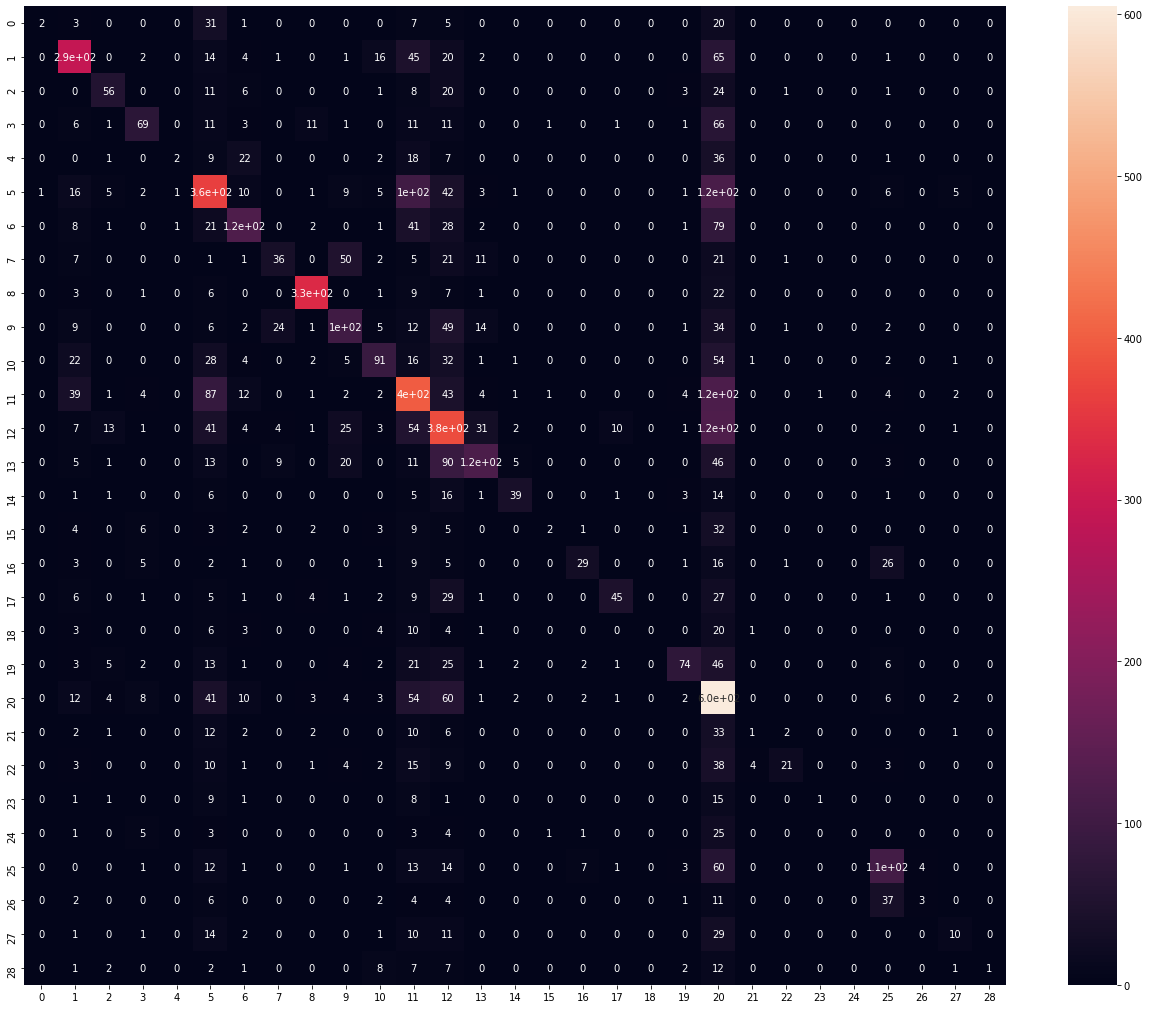

In [62]:
df_cm = pd.DataFrame(metrics.confusion_matrix(valid_y, predictions))
plt.figure(figsize = (22,18))
sn.heatmap(df_cm, annot=True)

## SVM Model

In [33]:
# SVM on Ngram Level TF IDF Vectors
accuracy, f1score = train_model(svm.SVC(), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVM, WordLevel TF-IDF: ", accuracy, 'and f1_score :', f1score)

# SVM on Ngram Level TF IDF Vectors
accuracy, f1score = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVM, N-Gram Vectors: ", accuracy, 'and f1_score :', f1score)

SVM, WordLevel TF-IDF:  0.45258745302110437 and f1_score : 0.43677326805816213
SVM, N-Gram Vectors:  0.45258745302110437 and f1_score : 0.43677326805816213


## Bagging Model : random forest

In [34]:
# RF on Word Level TF IDF Vectors
accuracy, f1score = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", accuracy, 'and f1_score :', f1score)

# RF on Ngram Level TF IDF Vectors
accuracy, f1score = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("RF, WordLevel TF-IDF: ", accuracy, 'and f1_score :', f1score)

RF, WordLevel TF-IDF:  0.46863255276091353 and f1_score : 0.4581814353379427
RF, WordLevel TF-IDF:  0.4670424978317433 and f1_score : 0.4569875612775437


# Enregistrement du modèle

In [37]:
model = best_logreg

In [68]:
# save the model
joblib.dump(model, 'model.pkl')
joblib.dump(tfidf_vect_ngram, 'tfidf.pkl')
joblib.dump(encoder, 'encoder.pkl')

['encoder.pkl']